<a href="https://colab.research.google.com/github/jarcenav/HW1_ECGR4106/blob/main/Project1_PT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting workspace

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# %cd /content/drive/MyDrive/Colab Notebooks/Real_ML_Project


In [32]:
import os
import pathlib
import torch

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


list of files and create testing/validation/training sets

In [34]:
import pandas as pd
from pathlib import Path
import glob



download_path = Path.cwd()/'/content/drive/MyDrive/dataset_ML'
path = '/content/drive/MyDrive/dataset_ML/GENRES_ORIGINAL'
single_path = '/content/drive/MyDrive/dataset_ML/GENRES_ORIGINAL/JAZZ/jazz00001.wav'
# Read metadata file
metadata_file = download_path/'Copy_of_features_30_sec.csv - features_30_sec.csv'
df = pd.read_csv(metadata_file)
df.head()

files = glob.glob(str(path) + '/*/*.wav')


df['relative_path'] = files

df = df[['relative_path', 'ClassID']]

df.head()


,relative_path,ClassID
0,/content/drive/MyDrive/dataset_ML/GENRES_ORIGI...,0
1,/content/drive/MyDrive/dataset_ML/GENRES_ORIGI...,0
2,/content/drive/MyDrive/dataset_ML/GENRES_ORIGI...,0
3,/content/drive/MyDrive/dataset_ML/GENRES_ORIGI...,0
4,/content/drive/MyDrive/dataset_ML/GENRES_ORIGI...,0


Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 22050


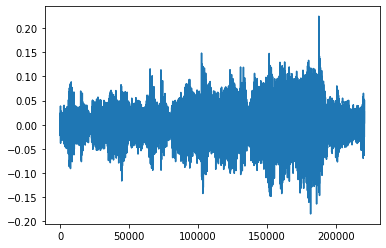

In [35]:
import torchaudio
import matplotlib.pyplot as plt

filename = single_path
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([1, 128, 1103])


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


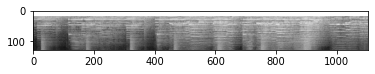

In [36]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

In [37]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)


  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))



  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)


  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)


  
  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)


  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec


  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]

    return ((resig, sr))

In [38]:

from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 220500
    self.sr = 22050
    self.channel = 1
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file =self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'ClassID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

Standarize sampling rate

In [39]:
from torch.utils.data import random_split

myds = SoundDS(df, path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, **kwargs)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, **kwargs)



In [43]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# # Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [44]:
# ----------------------------
# Training Loop
# ----------------------------
from tqdm import tqdm


def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in tqdm(enumerate(train_dl)):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')



In [47]:
num_epochs=300   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

5it [00:12,  2.42s/it]


Epoch: 0, Loss: 1.79, Accuracy: 0.30


5it [00:11,  2.40s/it]


Epoch: 1, Loss: 1.75, Accuracy: 0.34


5it [00:11,  2.37s/it]


Epoch: 2, Loss: 1.79, Accuracy: 0.36


5it [00:12,  2.43s/it]


Epoch: 3, Loss: 1.73, Accuracy: 0.30


5it [00:12,  2.41s/it]


Epoch: 4, Loss: 1.93, Accuracy: 0.26


5it [00:11,  2.37s/it]


Epoch: 5, Loss: 1.85, Accuracy: 0.31


5it [00:12,  2.40s/it]


Epoch: 6, Loss: 1.82, Accuracy: 0.33


5it [00:12,  2.41s/it]


Epoch: 7, Loss: 1.81, Accuracy: 0.30


5it [00:11,  2.39s/it]


Epoch: 8, Loss: 1.86, Accuracy: 0.29


5it [00:11,  2.38s/it]


Epoch: 9, Loss: 1.78, Accuracy: 0.35


5it [00:12,  2.40s/it]


Epoch: 10, Loss: 1.84, Accuracy: 0.31


5it [00:11,  2.40s/it]


Epoch: 11, Loss: 1.82, Accuracy: 0.29


5it [00:11,  2.39s/it]


Epoch: 12, Loss: 1.77, Accuracy: 0.39


5it [00:11,  2.38s/it]


Epoch: 13, Loss: 1.83, Accuracy: 0.30


5it [00:12,  2.41s/it]


Epoch: 14, Loss: 1.77, Accuracy: 0.33


5it [00:11,  2.39s/it]


Epoch: 15, Loss: 1.83, Accuracy: 0.34


5it [00:11,  2.39s/it]


Epoch: 16, Loss: 1.74, Accuracy: 0.38


5it [00:11,  2.38s/it]


Epoch: 17, Loss: 1.92, Accuracy: 0.31


5it [00:12,  2.42s/it]


Epoch: 18, Loss: 1.77, Accuracy: 0.35


5it [00:12,  2.42s/it]


Epoch: 19, Loss: 1.79, Accuracy: 0.34


5it [00:11,  2.40s/it]


Epoch: 20, Loss: 1.77, Accuracy: 0.36


5it [00:12,  2.40s/it]


Epoch: 21, Loss: 1.85, Accuracy: 0.29


5it [00:11,  2.37s/it]


Epoch: 22, Loss: 1.74, Accuracy: 0.34


5it [00:12,  2.44s/it]


Epoch: 23, Loss: 1.86, Accuracy: 0.26


5it [00:12,  2.41s/it]


Epoch: 24, Loss: 1.79, Accuracy: 0.34


5it [00:12,  2.41s/it]


Epoch: 25, Loss: 1.77, Accuracy: 0.35


5it [00:12,  2.41s/it]


Epoch: 26, Loss: 1.79, Accuracy: 0.29


5it [00:12,  2.41s/it]


Epoch: 27, Loss: 1.78, Accuracy: 0.36


5it [00:11,  2.39s/it]


Epoch: 28, Loss: 1.85, Accuracy: 0.33


5it [00:11,  2.39s/it]


Epoch: 29, Loss: 1.70, Accuracy: 0.40


5it [00:12,  2.40s/it]


Epoch: 30, Loss: 1.82, Accuracy: 0.33


5it [00:12,  2.42s/it]


Epoch: 31, Loss: 1.77, Accuracy: 0.39


5it [00:11,  2.39s/it]


Epoch: 32, Loss: 1.70, Accuracy: 0.35


5it [00:11,  2.39s/it]


Epoch: 33, Loss: 1.83, Accuracy: 0.33


5it [00:12,  2.41s/it]


Epoch: 34, Loss: 1.76, Accuracy: 0.38


5it [00:11,  2.40s/it]


Epoch: 35, Loss: 1.83, Accuracy: 0.34


5it [00:11,  2.37s/it]


Epoch: 36, Loss: 1.74, Accuracy: 0.29


5it [00:11,  2.40s/it]


Epoch: 37, Loss: 1.76, Accuracy: 0.31


5it [00:12,  2.41s/it]


Epoch: 38, Loss: 1.84, Accuracy: 0.24


5it [00:12,  2.42s/it]


Epoch: 39, Loss: 1.77, Accuracy: 0.30


5it [00:11,  2.39s/it]


Epoch: 40, Loss: 1.86, Accuracy: 0.29


5it [00:11,  2.40s/it]


Epoch: 41, Loss: 1.72, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 42, Loss: 1.81, Accuracy: 0.34


5it [00:11,  2.40s/it]


Epoch: 43, Loss: 1.78, Accuracy: 0.38


5it [00:11,  2.39s/it]


Epoch: 44, Loss: 1.76, Accuracy: 0.30


5it [00:12,  2.41s/it]


Epoch: 45, Loss: 1.96, Accuracy: 0.29


5it [00:11,  2.40s/it]


Epoch: 46, Loss: 1.77, Accuracy: 0.34


5it [00:12,  2.40s/it]


Epoch: 47, Loss: 1.76, Accuracy: 0.33


5it [00:12,  2.41s/it]


Epoch: 48, Loss: 1.82, Accuracy: 0.30


5it [00:11,  2.37s/it]


Epoch: 49, Loss: 1.73, Accuracy: 0.33


5it [00:12,  2.41s/it]


Epoch: 50, Loss: 1.79, Accuracy: 0.28


5it [00:12,  2.42s/it]


Epoch: 51, Loss: 1.89, Accuracy: 0.33


5it [00:11,  2.40s/it]


Epoch: 52, Loss: 1.94, Accuracy: 0.25


5it [00:12,  2.43s/it]


Epoch: 53, Loss: 1.84, Accuracy: 0.33


5it [00:11,  2.37s/it]


Epoch: 54, Loss: 1.84, Accuracy: 0.26


5it [00:11,  2.38s/it]


Epoch: 55, Loss: 1.80, Accuracy: 0.33


5it [00:11,  2.38s/it]


Epoch: 56, Loss: 1.85, Accuracy: 0.34


5it [00:12,  2.40s/it]


Epoch: 57, Loss: 1.86, Accuracy: 0.31


5it [00:11,  2.37s/it]


Epoch: 58, Loss: 1.80, Accuracy: 0.33


5it [00:12,  2.40s/it]


Epoch: 59, Loss: 1.81, Accuracy: 0.29


5it [00:12,  2.41s/it]


Epoch: 60, Loss: 1.75, Accuracy: 0.31


5it [00:11,  2.37s/it]


Epoch: 61, Loss: 1.74, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 62, Loss: 1.72, Accuracy: 0.36


5it [00:12,  2.41s/it]


Epoch: 63, Loss: 1.77, Accuracy: 0.36


5it [00:11,  2.39s/it]


Epoch: 64, Loss: 1.82, Accuracy: 0.31


5it [00:11,  2.38s/it]


Epoch: 65, Loss: 1.80, Accuracy: 0.39


5it [00:11,  2.40s/it]


Epoch: 66, Loss: 1.74, Accuracy: 0.31


5it [00:11,  2.38s/it]


Epoch: 67, Loss: 1.88, Accuracy: 0.28


5it [00:11,  2.39s/it]


Epoch: 68, Loss: 1.81, Accuracy: 0.33


5it [00:11,  2.36s/it]


Epoch: 69, Loss: 1.80, Accuracy: 0.36


5it [00:11,  2.40s/it]


Epoch: 70, Loss: 1.76, Accuracy: 0.39


5it [00:12,  2.40s/it]


Epoch: 71, Loss: 1.96, Accuracy: 0.21


5it [00:12,  2.40s/it]


Epoch: 72, Loss: 1.70, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 73, Loss: 1.85, Accuracy: 0.30


5it [00:12,  2.40s/it]


Epoch: 74, Loss: 1.83, Accuracy: 0.26


5it [00:11,  2.38s/it]


Epoch: 75, Loss: 1.76, Accuracy: 0.34


5it [00:11,  2.35s/it]


Epoch: 76, Loss: 1.86, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 77, Loss: 1.82, Accuracy: 0.28


5it [00:12,  2.42s/it]


Epoch: 78, Loss: 1.79, Accuracy: 0.28


5it [00:11,  2.39s/it]


Epoch: 79, Loss: 1.77, Accuracy: 0.34


5it [00:11,  2.39s/it]


Epoch: 80, Loss: 1.75, Accuracy: 0.34


5it [00:11,  2.37s/it]


Epoch: 81, Loss: 1.76, Accuracy: 0.31


5it [00:12,  2.40s/it]


Epoch: 82, Loss: 1.67, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 83, Loss: 1.80, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 84, Loss: 1.76, Accuracy: 0.36


5it [00:12,  2.40s/it]


Epoch: 85, Loss: 1.69, Accuracy: 0.38


5it [00:12,  2.42s/it]


Epoch: 86, Loss: 1.75, Accuracy: 0.36


5it [00:11,  2.38s/it]


Epoch: 87, Loss: 1.68, Accuracy: 0.42


5it [00:11,  2.36s/it]


Epoch: 88, Loss: 1.71, Accuracy: 0.31


5it [00:11,  2.37s/it]


Epoch: 89, Loss: 1.78, Accuracy: 0.30


5it [00:11,  2.38s/it]


Epoch: 90, Loss: 1.73, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 91, Loss: 1.79, Accuracy: 0.29


5it [00:11,  2.36s/it]


Epoch: 92, Loss: 1.64, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 93, Loss: 1.72, Accuracy: 0.33


5it [00:12,  2.42s/it]


Epoch: 94, Loss: 1.70, Accuracy: 0.39


5it [00:11,  2.40s/it]


Epoch: 95, Loss: 1.75, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 96, Loss: 1.79, Accuracy: 0.29


5it [00:11,  2.39s/it]


Epoch: 97, Loss: 1.72, Accuracy: 0.36


5it [00:11,  2.39s/it]


Epoch: 98, Loss: 1.72, Accuracy: 0.33


5it [00:11,  2.39s/it]


Epoch: 99, Loss: 1.79, Accuracy: 0.34


5it [00:11,  2.36s/it]


Epoch: 100, Loss: 1.78, Accuracy: 0.30


5it [00:11,  2.39s/it]


Epoch: 101, Loss: 1.85, Accuracy: 0.30


5it [00:11,  2.38s/it]


Epoch: 102, Loss: 1.72, Accuracy: 0.40


5it [00:11,  2.35s/it]


Epoch: 103, Loss: 1.75, Accuracy: 0.33


5it [00:11,  2.39s/it]


Epoch: 104, Loss: 1.92, Accuracy: 0.29


5it [00:12,  2.44s/it]


Epoch: 105, Loss: 1.72, Accuracy: 0.35


5it [00:11,  2.39s/it]


Epoch: 106, Loss: 1.67, Accuracy: 0.33


5it [00:11,  2.37s/it]


Epoch: 107, Loss: 1.88, Accuracy: 0.26


5it [00:11,  2.39s/it]


Epoch: 108, Loss: 1.75, Accuracy: 0.29


5it [00:11,  2.39s/it]


Epoch: 109, Loss: 1.81, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 110, Loss: 1.69, Accuracy: 0.39


5it [00:12,  2.40s/it]


Epoch: 111, Loss: 1.63, Accuracy: 0.42


5it [00:11,  2.37s/it]


Epoch: 112, Loss: 1.72, Accuracy: 0.31


5it [00:11,  2.39s/it]


Epoch: 113, Loss: 1.78, Accuracy: 0.30


5it [00:11,  2.39s/it]


Epoch: 114, Loss: 1.81, Accuracy: 0.28


5it [00:11,  2.38s/it]


Epoch: 115, Loss: 1.79, Accuracy: 0.26


5it [00:11,  2.35s/it]


Epoch: 116, Loss: 1.76, Accuracy: 0.33


5it [00:11,  2.39s/it]


Epoch: 117, Loss: 1.77, Accuracy: 0.35


5it [00:11,  2.39s/it]


Epoch: 118, Loss: 1.76, Accuracy: 0.26


5it [00:11,  2.40s/it]


Epoch: 119, Loss: 1.82, Accuracy: 0.25


5it [00:11,  2.38s/it]


Epoch: 120, Loss: 1.84, Accuracy: 0.31


5it [00:11,  2.40s/it]


Epoch: 121, Loss: 1.74, Accuracy: 0.31


5it [00:11,  2.37s/it]


Epoch: 122, Loss: 1.75, Accuracy: 0.38


5it [00:11,  2.36s/it]


Epoch: 123, Loss: 1.75, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 124, Loss: 1.65, Accuracy: 0.31


5it [00:12,  2.41s/it]


Epoch: 125, Loss: 1.68, Accuracy: 0.38


5it [00:11,  2.37s/it]


Epoch: 126, Loss: 1.70, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 127, Loss: 1.67, Accuracy: 0.42


5it [00:11,  2.38s/it]


Epoch: 128, Loss: 1.70, Accuracy: 0.36


5it [00:11,  2.40s/it]


Epoch: 129, Loss: 1.72, Accuracy: 0.34


5it [00:11,  2.36s/it]


Epoch: 130, Loss: 1.61, Accuracy: 0.42


5it [00:11,  2.39s/it]


Epoch: 131, Loss: 1.79, Accuracy: 0.31


5it [00:12,  2.40s/it]


Epoch: 132, Loss: 1.73, Accuracy: 0.34


5it [00:11,  2.38s/it]


Epoch: 133, Loss: 1.67, Accuracy: 0.35


5it [00:11,  2.38s/it]


Epoch: 134, Loss: 1.72, Accuracy: 0.41


5it [00:12,  2.40s/it]


Epoch: 135, Loss: 1.76, Accuracy: 0.31


5it [00:12,  2.40s/it]


Epoch: 136, Loss: 1.93, Accuracy: 0.28


5it [00:11,  2.38s/it]


Epoch: 137, Loss: 1.69, Accuracy: 0.36


5it [00:12,  2.42s/it]


Epoch: 138, Loss: 1.65, Accuracy: 0.42


5it [00:12,  2.41s/it]


Epoch: 139, Loss: 1.84, Accuracy: 0.28


5it [00:11,  2.39s/it]


Epoch: 140, Loss: 1.71, Accuracy: 0.40


5it [00:11,  2.38s/it]


Epoch: 141, Loss: 1.71, Accuracy: 0.34


5it [00:12,  2.40s/it]


Epoch: 142, Loss: 1.63, Accuracy: 0.39


5it [00:11,  2.39s/it]


Epoch: 143, Loss: 1.71, Accuracy: 0.35


5it [00:11,  2.38s/it]


Epoch: 144, Loss: 1.70, Accuracy: 0.38


5it [00:11,  2.37s/it]


Epoch: 145, Loss: 1.77, Accuracy: 0.35


5it [00:12,  2.42s/it]


Epoch: 146, Loss: 1.63, Accuracy: 0.40


5it [00:12,  2.42s/it]


Epoch: 147, Loss: 1.84, Accuracy: 0.29


5it [00:11,  2.38s/it]


Epoch: 148, Loss: 1.67, Accuracy: 0.41


5it [00:11,  2.38s/it]


Epoch: 149, Loss: 1.71, Accuracy: 0.41


5it [00:11,  2.38s/it]


Epoch: 150, Loss: 1.78, Accuracy: 0.33


5it [00:12,  2.41s/it]


Epoch: 151, Loss: 1.63, Accuracy: 0.40


5it [00:11,  2.39s/it]


Epoch: 152, Loss: 1.66, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 153, Loss: 1.63, Accuracy: 0.44


5it [00:12,  2.41s/it]


Epoch: 154, Loss: 1.66, Accuracy: 0.41


5it [00:11,  2.39s/it]


Epoch: 155, Loss: 1.70, Accuracy: 0.39


5it [00:11,  2.36s/it]


Epoch: 156, Loss: 1.72, Accuracy: 0.34


5it [00:11,  2.35s/it]


Epoch: 157, Loss: 1.65, Accuracy: 0.40


5it [00:12,  2.43s/it]


Epoch: 158, Loss: 1.65, Accuracy: 0.42


5it [00:11,  2.37s/it]


Epoch: 159, Loss: 1.76, Accuracy: 0.35


5it [00:11,  2.37s/it]


Epoch: 160, Loss: 1.63, Accuracy: 0.46


5it [00:12,  2.42s/it]


Epoch: 161, Loss: 1.71, Accuracy: 0.34


5it [00:11,  2.38s/it]


Epoch: 162, Loss: 1.71, Accuracy: 0.35


5it [00:11,  2.38s/it]


Epoch: 163, Loss: 1.64, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 164, Loss: 1.68, Accuracy: 0.38


5it [00:12,  2.42s/it]


Epoch: 165, Loss: 1.67, Accuracy: 0.34


5it [00:12,  2.42s/it]


Epoch: 166, Loss: 1.72, Accuracy: 0.36


5it [00:11,  2.37s/it]


Epoch: 167, Loss: 1.68, Accuracy: 0.38


5it [00:11,  2.40s/it]


Epoch: 168, Loss: 1.72, Accuracy: 0.34


5it [00:12,  2.42s/it]


Epoch: 169, Loss: 1.80, Accuracy: 0.36


5it [00:11,  2.39s/it]


Epoch: 170, Loss: 1.60, Accuracy: 0.40


5it [00:11,  2.37s/it]


Epoch: 171, Loss: 1.78, Accuracy: 0.30


5it [00:11,  2.36s/it]


Epoch: 172, Loss: 1.85, Accuracy: 0.39


5it [00:12,  2.42s/it]


Epoch: 173, Loss: 1.63, Accuracy: 0.44


5it [00:12,  2.43s/it]


Epoch: 174, Loss: 1.73, Accuracy: 0.40


5it [00:11,  2.38s/it]


Epoch: 175, Loss: 1.82, Accuracy: 0.40


5it [00:11,  2.38s/it]


Epoch: 176, Loss: 1.75, Accuracy: 0.36


5it [00:11,  2.36s/it]


Epoch: 177, Loss: 1.70, Accuracy: 0.39


5it [00:11,  2.36s/it]


Epoch: 178, Loss: 1.63, Accuracy: 0.39


5it [00:11,  2.39s/it]


Epoch: 179, Loss: 1.68, Accuracy: 0.39


5it [00:11,  2.39s/it]


Epoch: 180, Loss: 1.63, Accuracy: 0.39


5it [00:11,  2.39s/it]


Epoch: 181, Loss: 1.72, Accuracy: 0.38


5it [00:11,  2.36s/it]


Epoch: 182, Loss: 1.67, Accuracy: 0.29


5it [00:12,  2.42s/it]


Epoch: 183, Loss: 1.79, Accuracy: 0.39


5it [00:11,  2.37s/it]


Epoch: 184, Loss: 1.87, Accuracy: 0.29


5it [00:11,  2.40s/it]


Epoch: 185, Loss: 1.86, Accuracy: 0.31


5it [00:11,  2.39s/it]


Epoch: 186, Loss: 1.72, Accuracy: 0.36


5it [00:12,  2.42s/it]


Epoch: 187, Loss: 1.60, Accuracy: 0.45


5it [00:12,  2.41s/it]


Epoch: 188, Loss: 1.81, Accuracy: 0.38


5it [00:12,  2.41s/it]


Epoch: 189, Loss: 1.77, Accuracy: 0.38


5it [00:12,  2.40s/it]


Epoch: 190, Loss: 1.69, Accuracy: 0.38


5it [00:11,  2.35s/it]


Epoch: 191, Loss: 1.64, Accuracy: 0.38


5it [00:12,  2.42s/it]


Epoch: 192, Loss: 1.69, Accuracy: 0.42


5it [00:12,  2.40s/it]


Epoch: 193, Loss: 1.63, Accuracy: 0.44


5it [00:11,  2.37s/it]


Epoch: 194, Loss: 1.67, Accuracy: 0.40


5it [00:11,  2.38s/it]


Epoch: 195, Loss: 1.66, Accuracy: 0.40


5it [00:12,  2.41s/it]


Epoch: 196, Loss: 1.72, Accuracy: 0.25


5it [00:11,  2.38s/it]


Epoch: 197, Loss: 1.75, Accuracy: 0.36


5it [00:12,  2.41s/it]


Epoch: 198, Loss: 1.65, Accuracy: 0.45


5it [00:11,  2.38s/it]


Epoch: 199, Loss: 1.65, Accuracy: 0.44


5it [00:12,  2.41s/it]


Epoch: 200, Loss: 1.57, Accuracy: 0.44


5it [00:11,  2.37s/it]


Epoch: 201, Loss: 1.90, Accuracy: 0.28


5it [00:11,  2.35s/it]


Epoch: 202, Loss: 1.72, Accuracy: 0.41


5it [00:11,  2.39s/it]


Epoch: 203, Loss: 1.66, Accuracy: 0.47


5it [00:11,  2.36s/it]


Epoch: 204, Loss: 1.64, Accuracy: 0.39


5it [00:11,  2.38s/it]


Epoch: 205, Loss: 1.58, Accuracy: 0.46


5it [00:11,  2.39s/it]


Epoch: 206, Loss: 1.65, Accuracy: 0.39


5it [00:11,  2.39s/it]


Epoch: 207, Loss: 1.63, Accuracy: 0.33


5it [00:11,  2.40s/it]


Epoch: 208, Loss: 1.69, Accuracy: 0.38


5it [00:11,  2.39s/it]


Epoch: 209, Loss: 1.63, Accuracy: 0.41


5it [00:11,  2.35s/it]


Epoch: 210, Loss: 1.54, Accuracy: 0.44


5it [00:11,  2.36s/it]


Epoch: 211, Loss: 1.60, Accuracy: 0.42


5it [00:12,  2.41s/it]


Epoch: 212, Loss: 1.68, Accuracy: 0.41


5it [00:11,  2.39s/it]


Epoch: 213, Loss: 1.69, Accuracy: 0.36


5it [00:11,  2.37s/it]


Epoch: 214, Loss: 1.59, Accuracy: 0.42


5it [00:11,  2.39s/it]


Epoch: 215, Loss: 1.61, Accuracy: 0.46


5it [00:12,  2.43s/it]


Epoch: 216, Loss: 1.63, Accuracy: 0.49


5it [00:11,  2.39s/it]


Epoch: 217, Loss: 1.68, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 218, Loss: 1.61, Accuracy: 0.41


5it [00:11,  2.36s/it]


Epoch: 219, Loss: 1.56, Accuracy: 0.44


5it [00:11,  2.37s/it]


Epoch: 220, Loss: 1.57, Accuracy: 0.45


5it [00:11,  2.39s/it]


Epoch: 221, Loss: 1.63, Accuracy: 0.44


5it [00:12,  2.40s/it]


Epoch: 222, Loss: 1.53, Accuracy: 0.50


5it [00:12,  2.41s/it]


Epoch: 223, Loss: 1.62, Accuracy: 0.40


5it [00:11,  2.39s/it]


Epoch: 224, Loss: 1.65, Accuracy: 0.41


5it [00:11,  2.39s/it]


Epoch: 225, Loss: 1.66, Accuracy: 0.38


5it [00:11,  2.39s/it]


Epoch: 226, Loss: 1.66, Accuracy: 0.40


5it [00:11,  2.39s/it]


Epoch: 227, Loss: 1.73, Accuracy: 0.34


5it [00:12,  2.45s/it]


Epoch: 228, Loss: 1.62, Accuracy: 0.39


5it [00:11,  2.38s/it]


Epoch: 229, Loss: 1.56, Accuracy: 0.40


5it [00:11,  2.39s/it]


Epoch: 230, Loss: 1.58, Accuracy: 0.44


5it [00:11,  2.36s/it]


Epoch: 231, Loss: 1.58, Accuracy: 0.46


5it [00:11,  2.38s/it]


Epoch: 232, Loss: 1.60, Accuracy: 0.39


5it [00:11,  2.38s/it]


Epoch: 233, Loss: 1.55, Accuracy: 0.47


5it [00:11,  2.38s/it]


Epoch: 234, Loss: 1.59, Accuracy: 0.40


5it [00:11,  2.38s/it]


Epoch: 235, Loss: 1.52, Accuracy: 0.41


5it [00:11,  2.37s/it]


Epoch: 236, Loss: 1.61, Accuracy: 0.41


5it [00:11,  2.36s/it]


Epoch: 237, Loss: 1.61, Accuracy: 0.44


5it [00:11,  2.35s/it]


Epoch: 238, Loss: 1.66, Accuracy: 0.42


5it [00:12,  2.42s/it]


Epoch: 239, Loss: 1.65, Accuracy: 0.42


5it [00:11,  2.39s/it]


Epoch: 240, Loss: 1.58, Accuracy: 0.40


5it [00:12,  2.41s/it]


Epoch: 241, Loss: 1.63, Accuracy: 0.49


5it [00:12,  2.40s/it]


Epoch: 242, Loss: 1.61, Accuracy: 0.46


5it [00:12,  2.42s/it]


Epoch: 243, Loss: 1.59, Accuracy: 0.45


5it [00:11,  2.38s/it]


Epoch: 244, Loss: 1.83, Accuracy: 0.34


5it [00:11,  2.37s/it]


Epoch: 245, Loss: 1.61, Accuracy: 0.38


5it [00:12,  2.41s/it]


Epoch: 246, Loss: 1.63, Accuracy: 0.41


5it [00:11,  2.38s/it]


Epoch: 247, Loss: 1.54, Accuracy: 0.39


5it [00:11,  2.40s/it]


Epoch: 248, Loss: 1.65, Accuracy: 0.42


5it [00:11,  2.39s/it]


Epoch: 249, Loss: 1.60, Accuracy: 0.38


5it [00:12,  2.45s/it]


Epoch: 250, Loss: 1.70, Accuracy: 0.41


5it [00:11,  2.38s/it]


Epoch: 251, Loss: 1.52, Accuracy: 0.47


5it [00:11,  2.37s/it]


Epoch: 252, Loss: 1.62, Accuracy: 0.40


5it [00:11,  2.40s/it]


Epoch: 253, Loss: 1.65, Accuracy: 0.36


5it [00:12,  2.43s/it]


Epoch: 254, Loss: 1.59, Accuracy: 0.45


5it [00:12,  2.40s/it]


Epoch: 255, Loss: 1.73, Accuracy: 0.39


5it [00:11,  2.36s/it]


Epoch: 256, Loss: 1.62, Accuracy: 0.35


5it [00:12,  2.40s/it]


Epoch: 257, Loss: 1.66, Accuracy: 0.46


5it [00:11,  2.36s/it]


Epoch: 258, Loss: 1.66, Accuracy: 0.40


5it [00:11,  2.38s/it]


Epoch: 259, Loss: 1.67, Accuracy: 0.41


5it [00:12,  2.41s/it]


Epoch: 260, Loss: 1.59, Accuracy: 0.40


5it [00:11,  2.38s/it]


Epoch: 261, Loss: 1.59, Accuracy: 0.41


5it [00:12,  2.40s/it]


Epoch: 262, Loss: 1.61, Accuracy: 0.45


5it [00:11,  2.40s/it]


Epoch: 263, Loss: 1.58, Accuracy: 0.41


5it [00:11,  2.38s/it]


Epoch: 264, Loss: 1.63, Accuracy: 0.33


5it [00:11,  2.37s/it]


Epoch: 265, Loss: 1.54, Accuracy: 0.45


5it [00:12,  2.41s/it]


Epoch: 266, Loss: 1.54, Accuracy: 0.44


5it [00:11,  2.39s/it]


Epoch: 267, Loss: 1.59, Accuracy: 0.41


5it [00:11,  2.39s/it]


Epoch: 268, Loss: 1.60, Accuracy: 0.36


5it [00:12,  2.40s/it]


Epoch: 269, Loss: 1.53, Accuracy: 0.46


5it [00:12,  2.40s/it]


Epoch: 270, Loss: 1.61, Accuracy: 0.45


5it [00:12,  2.40s/it]


Epoch: 271, Loss: 1.66, Accuracy: 0.35


5it [00:11,  2.36s/it]


Epoch: 272, Loss: 1.56, Accuracy: 0.51


5it [00:12,  2.43s/it]


Epoch: 273, Loss: 1.73, Accuracy: 0.38


5it [00:12,  2.43s/it]


Epoch: 274, Loss: 1.82, Accuracy: 0.26


5it [00:12,  2.41s/it]


Epoch: 275, Loss: 1.59, Accuracy: 0.45


5it [00:12,  2.41s/it]


Epoch: 276, Loss: 1.60, Accuracy: 0.47


5it [00:11,  2.39s/it]


Epoch: 277, Loss: 1.72, Accuracy: 0.33


5it [00:11,  2.35s/it]


Epoch: 278, Loss: 1.63, Accuracy: 0.41


5it [00:12,  2.41s/it]


Epoch: 279, Loss: 1.71, Accuracy: 0.34


5it [00:12,  2.41s/it]


Epoch: 280, Loss: 1.65, Accuracy: 0.41


5it [00:11,  2.39s/it]


Epoch: 281, Loss: 1.57, Accuracy: 0.39


5it [00:12,  2.43s/it]


Epoch: 282, Loss: 1.55, Accuracy: 0.41


5it [00:12,  2.41s/it]


Epoch: 283, Loss: 1.66, Accuracy: 0.44


5it [00:11,  2.36s/it]


Epoch: 284, Loss: 1.50, Accuracy: 0.51


5it [00:11,  2.35s/it]


Epoch: 285, Loss: 1.55, Accuracy: 0.44


5it [00:12,  2.42s/it]


Epoch: 286, Loss: 1.52, Accuracy: 0.51


5it [00:12,  2.42s/it]


Epoch: 287, Loss: 1.63, Accuracy: 0.39


5it [00:12,  2.41s/it]


Epoch: 288, Loss: 1.62, Accuracy: 0.41


5it [00:11,  2.39s/it]


Epoch: 289, Loss: 1.51, Accuracy: 0.44


5it [00:12,  2.43s/it]


Epoch: 290, Loss: 1.58, Accuracy: 0.44


5it [00:11,  2.40s/it]


Epoch: 291, Loss: 1.60, Accuracy: 0.40


5it [00:11,  2.37s/it]


Epoch: 292, Loss: 1.61, Accuracy: 0.36


5it [00:12,  2.41s/it]


Epoch: 293, Loss: 1.54, Accuracy: 0.45


5it [00:11,  2.38s/it]


Epoch: 294, Loss: 1.75, Accuracy: 0.36


5it [00:12,  2.41s/it]


Epoch: 295, Loss: 1.54, Accuracy: 0.44


5it [00:12,  2.43s/it]


Epoch: 296, Loss: 1.57, Accuracy: 0.50


5it [00:11,  2.40s/it]


Epoch: 297, Loss: 1.66, Accuracy: 0.41


5it [00:11,  2.38s/it]


Epoch: 298, Loss: 1.57, Accuracy: 0.47


5it [00:11,  2.36s/it]

Epoch: 299, Loss: 1.57, Accuracy: 0.42
Finished Training


In [48]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.45, Total items: 20
